In [1]:
import folktables
from folktables import ACSDataSource, ACSEmployment, ACSIncome
from xgboost import XGBClassifier
from skrub import tabular_learner

import sklearn as sk
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error,confusion_matrix,roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from scipy.stats import ks_2samp,uniform,norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
file_1 = pd.read_csv("csv_pus/psam_pusa.csv",sep=",")
file_1

/tmp/ipykernel_10244/106231353.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  file_1 = pd.read_csv("csv_pus/psam_pusa.csv",sep=",")


,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2014000000007,6,1,2400,3,1,1070673,7,49,...,6,8,8,7,1,4,8,9,3,9
1,P,2014000000007,6,2,2400,3,1,1070673,8,59,...,8,5,9,8,3,3,7,8,1,8
2,P,2014000000007,6,3,2400,3,1,1070673,26,37,...,22,26,28,23,12,11,23,32,7,52
3,P,2014000000007,6,4,2400,3,1,1070673,14,15,...,14,23,15,12,5,4,14,15,5,23
4,P,2014000000007,6,5,2400,3,1,1070673,14,14,...,11,20,16,13,5,3,13,15,5,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4723104,P,2018HU1400120,9,2,200,4,15,1013097,4,10,...,3,6,4,0,4,3,5,3,3,2
4723105,P,2018HU1400120,9,3,200,4,15,1013097,4,44,...,4,8,4,1,4,5,6,5,2,2
4723106,P,2018HU1400479,9,1,303,4,15,1013097,14,53,...,25,14,15,25,4,12,13,20,4,13
4723107,P,2018HU1400479,9,2,303,4,15,1013097,22,25,...,25,25,17,29,9,17,28,35,7,37


In [3]:
features_1,label_1,group_1 = ACSIncome.df_to_pandas(file_1)

features_1

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
0,49.0,6.0,16.0,1.0,7210.0,1.0,0.0,60.0,1.0,1.0
1,51.0,1.0,16.0,1.0,4220.0,1.0,0.0,40.0,1.0,1.0
2,53.0,1.0,16.0,1.0,7750.0,1.0,1.0,40.0,2.0,1.0
3,51.0,1.0,16.0,1.0,5610.0,19.0,0.0,40.0,1.0,1.0
4,48.0,5.0,20.0,1.0,7430.0,47.0,1.0,40.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2355861,44.0,6.0,16.0,3.0,6260.0,15.0,0.0,40.0,1.0,7.0
2355862,44.0,1.0,20.0,3.0,2014.0,15.0,13.0,40.0,2.0,6.0
2355863,53.0,5.0,20.0,4.0,2300.0,512.0,0.0,8.0,2.0,7.0
2355864,25.0,2.0,19.0,5.0,5410.0,511.0,2.0,40.0,1.0,7.0


In [4]:
file_2 = pd.read_csv("csv_pus/psam_pusb.csv",sep=",")
file_2

/tmp/ipykernel_14160/2175607024.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  file_2 = pd.read_csv("csv_pus/psam_pusb.csv",sep=",")


,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2014000000260,8,1,600,4,16,1070673,29,57,...,29,28,29,8,31,8,27,34,8,9
1,P,2014000000260,8,2,600,4,16,1070673,38,18,...,49,57,22,12,45,11,65,32,15,10
2,P,2014000000358,8,1,1300,4,16,1070673,14,63,...,23,25,24,14,15,14,15,15,3,28
3,P,2014000000358,8,2,1300,4,16,1070673,15,59,...,23,25,23,14,18,15,16,15,4,28
4,P,2014000000438,8,1,1100,4,16,1070673,14,54,...,6,19,20,31,19,12,33,4,17,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3417353,P,2018HU1400901,6,1,300,3,28,1013097,16,43,...,6,18,14,28,19,14,17,16,37,15
3417354,P,2018HU1400901,6,2,300,3,28,1013097,16,14,...,5,19,17,23,17,20,13,15,45,14
3417355,P,2018HU1400901,6,3,300,3,28,1013097,13,13,...,3,16,15,29,17,14,13,12,36,11
3417356,P,2018HU1400901,6,4,300,3,28,1013097,11,62,...,4,16,10,20,17,12,12,9,28,5


In [5]:
features_2,label_2,group_2 = ACSIncome.df_to_pandas(file_2)

features_2

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
0,59.0,1.0,19.0,1.0,5240.0,6.0,1.0,24.0,2.0,1.0
1,54.0,1.0,19.0,1.0,440.0,16.0,0.0,40.0,1.0,1.0
2,21.0,1.0,16.0,5.0,4010.0,16.0,2.0,25.0,2.0,1.0
3,61.0,1.0,21.0,3.0,6050.0,16.0,0.0,52.0,1.0,1.0
4,28.0,7.0,16.0,1.0,4700.0,16.0,0.0,4.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1777200,30.0,4.0,20.0,1.0,3220.0,28.0,1.0,40.0,2.0,2.0
1777201,43.0,1.0,16.0,2.0,3602.0,28.0,0.0,40.0,2.0,2.0
1777202,24.0,1.0,16.0,5.0,3601.0,28.0,5.0,35.0,2.0,2.0
1777203,43.0,1.0,21.0,5.0,5000.0,28.0,0.0,40.0,2.0,2.0


In [6]:
features_usa = pd.concat([features_1, features_2], ignore_index=True)
label_usa = pd.concat([label_1, label_2], ignore_index=True)
group_usa = pd.concat([group_1,group_2], ignore_index=True)

features_usa

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
0,49.0,6.0,16.0,1.0,7210.0,1.0,0.0,60.0,1.0,1.0
1,51.0,1.0,16.0,1.0,4220.0,1.0,0.0,40.0,1.0,1.0
2,53.0,1.0,16.0,1.0,7750.0,1.0,1.0,40.0,2.0,1.0
3,51.0,1.0,16.0,1.0,5610.0,19.0,0.0,40.0,1.0,1.0
4,48.0,5.0,20.0,1.0,7430.0,47.0,1.0,40.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...
4133066,30.0,4.0,20.0,1.0,3220.0,28.0,1.0,40.0,2.0,2.0
4133067,43.0,1.0,16.0,2.0,3602.0,28.0,0.0,40.0,2.0,2.0
4133068,24.0,1.0,16.0,5.0,3601.0,28.0,5.0,35.0,2.0,2.0
4133069,43.0,1.0,21.0,5.0,5000.0,28.0,0.0,40.0,2.0,2.0


In [7]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=['CA'], download=True)

features_ca, label_ca, group_ca = ACSIncome.df_to_pandas(acs_data)
features_ca

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
0,30.0,6.0,14.0,1.0,9610.0,6.0,16.0,40.0,1.0,8.0
1,21.0,4.0,16.0,5.0,1970.0,6.0,17.0,20.0,1.0,1.0
2,65.0,2.0,22.0,5.0,2040.0,6.0,17.0,8.0,1.0,1.0
3,33.0,1.0,14.0,3.0,9610.0,36.0,16.0,40.0,1.0,1.0
4,18.0,2.0,19.0,5.0,1021.0,6.0,17.0,18.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...
195660,38.0,1.0,22.0,1.0,1021.0,210.0,0.0,40.0,1.0,6.0
195661,39.0,1.0,22.0,1.0,1021.0,210.0,1.0,40.0,2.0,6.0
195662,61.0,1.0,19.0,1.0,5240.0,17.0,0.0,45.0,1.0,1.0
195663,69.0,7.0,24.0,1.0,2040.0,207.0,0.0,45.0,1.0,6.0


In [8]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=['TX'], download=True)

features_tx, label_tx, group_tx = ACSIncome.df_to_pandas(acs_data)
features_tx

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
0,21.0,3.0,16.0,5.0,3500.0,48.0,17.0,10.0,2.0,2.0
1,20.0,1.0,16.0,5.0,4720.0,39.0,17.0,50.0,2.0,1.0
2,31.0,1.0,17.0,5.0,4110.0,48.0,17.0,30.0,1.0,1.0
3,39.0,1.0,21.0,1.0,4255.0,18.0,16.0,40.0,1.0,1.0
4,18.0,1.0,16.0,5.0,4055.0,48.0,17.0,20.0,1.0,6.0
...,...,...,...,...,...,...,...,...,...,...
135919,19.0,1.0,19.0,5.0,9620.0,48.0,2.0,40.0,1.0,1.0
135920,24.0,1.0,19.0,5.0,4760.0,48.0,10.0,40.0,1.0,1.0
135921,40.0,1.0,15.0,5.0,6260.0,48.0,12.0,40.0,1.0,1.0
135922,43.0,1.0,1.0,2.0,6330.0,17.0,0.0,48.0,1.0,1.0


In [9]:
for col in features_ca.columns:
    print(col,":",ks_2samp(features_ca[col],features_tx[col])[1])

AGEP : 2.0545002594482424e-06
COW : 2.1681460778132778e-66
SCHL : 3.812151061762598e-205
MAR : 2.33803326870304e-264
OCCP : 1.2242502340698355e-96
POBP : 0.0
RELP : 6.201270404494092e-303
WKHP : 0.0
SEX : 0.31351008315299944
RAC1P : 0.0


In [10]:
from bias_measure_fcts import Cpt_DI,Cpt_EoO,Cpt_Suf
from math import sqrt

def phi(cm):
    n = len(str(np.max(cm)))
    cm_00 = cm[0,0]/10**n
    cm_01 = cm[0,1]/10**n
    cm_10 = cm[1,0]/10**n
    cm_11 = cm[1,1]/10**n
    return (cm_00*cm_11-cm_01*cm_10)/(sqrt((cm_00+cm_01)*(cm_01+cm_11)*(cm_11+cm_10)*(cm_10+cm_00)))

def comp_CM_per_state(state_data,state_model,model,model_name=""):
    features = globals()[f"features_{str(state_data)}"]
    label = globals()[f"label_{str(state_data)}"]

    features_model = globals()[f"features_{str(state_model)}"]
    label_model = globals()[f"label_{str(state_model)}"]

    X_train, X_test, Y_train, Y_test = train_test_split(features_model,label_model,train_size=0.7)


    if model_name == "NN":
        model.fit(X_train.values,Y_train.values.ravel(),epochs_nb=100,batch_size=300,optimizer='SGD')
    elif model_name == "Skrub":
        model.fit(X_train, Y_train)
    else:
        model.fit(X_train.values,Y_train.values.ravel())

    if state_data == state_model:   #Si les 2 Etats sont identiques, on fait la CM uniquement sur les données de test
                                    #pour ne pas biaiser avec la proportion en données d'entraînement mieux entraînée
        Y_test_pred = model.predict(X_test)
        print("Données :",state_data.upper(),"// Modèle fait sur :",state_model.upper())
        print(phi(confusion_matrix(Y_test,Y_test_pred)))
        print(confusion_matrix(Y_test,Y_test_pred),"\n")
        
        #2-X_test["SEX"].values : "1" = Homme et "0" = Femme
        print("       - Disparate Impact =",Cpt_DI(2-X_test["SEX"].values,Y_test_pred.ravel()))
        print("       - Equality of Odds =",Cpt_EoO(2-X_test["SEX"].values,Y_test_pred.ravel(),Y_test.values.ravel()))
        print("       - Sufficiency =",Cpt_Suf(2-X_test["SEX"].values,Y_test_pred.ravel(),Y_test.values.ravel()),"\n")
    
    else:
        Y_test_pred = model.predict(features)

        print("Données :",state_data.upper(),"// Modèle fait sur :",state_model.upper())
        print(phi(confusion_matrix(label,model.predict(features))))
        print(confusion_matrix(label,model.predict(features)),"\n")

        print("       - Disparate Impact =",Cpt_DI(2-features["SEX"].values,Y_test_pred.ravel()))
        print("       - Equality of Odds =",Cpt_EoO(2-features["SEX"].values,Y_test_pred.ravel(),label.values.ravel()))
        print("       - Sufficiency =",Cpt_Suf(2-features["SEX"].values,Y_test_pred.ravel(),label.values.ravel()),"\n")

### Régression logistique sur TX + prédiction sur USA

/home/luana/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Données : TX // Modèle fait sur : TX
0.5195816071850653
[[22185  3642]
 [ 5284  9667]] 

       - Disparate Impact = (0.46741011617373696, [0.45251676054279455, 0.48230347180467936])
       - Equality of Odds = (0.6740008508096366, [0.6541735064873884, 0.6938281951318848])
       - Sufficiency = (0.9357880658313489, [0.9132470212094279, 0.9583291104532699]) 



/home/luana/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Données : USA // Modèle fait sur : TX


/home/luana/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


0.5084694363632362


/home/luana/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[[2305995  389627]
 [ 515383  922066]] 

       - Disparate Impact = (0.46392028702304344, [0.4624358563076878, 0.4654047177383991])
       - Equality of Odds = (0.6731159278289297, [0.6711060333115766, 0.6751258223462828])
       - Sufficiency = (0.9471711539401239, [0.9447844073237068, 0.9495579005565409]) 



/home/luana/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


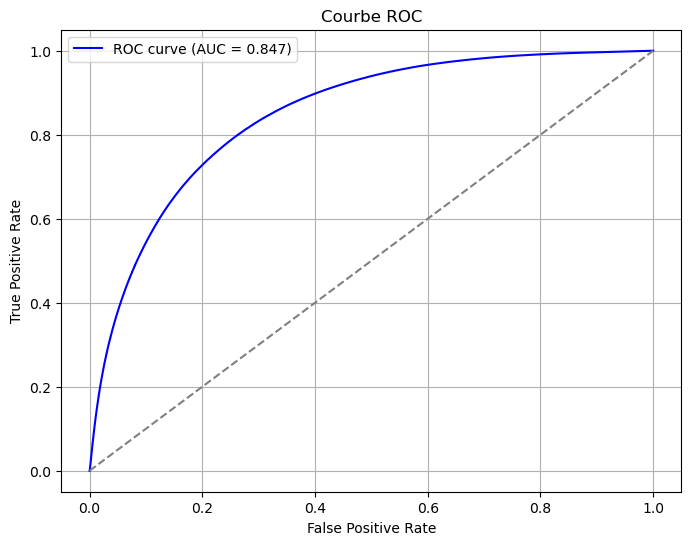

In [11]:
model = make_pipeline(StandardScaler(),LogisticRegression(solver="lbfgs",max_iter=10000))

comp_CM_per_state("tx","tx",model)
comp_CM_per_state("usa","tx",model)


y_probs = model.predict_proba(features_usa)[:, 1]

# Calcul des coordonnées ROC
fpr, tpr, thresholds = roc_curve(label_usa, y_probs)

# AUC
auc_score = roc_auc_score(label_usa, y_probs)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.3f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # ligne diagonale
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC")
plt.legend()
plt.grid(True)
plt.show()

### XG Boost sur TX + prédiction sur USA

Données : TX // Modèle fait sur : TX
0.6011103217302611
[[22404  3561]
 [ 3926 10887]] 

       - Disparate Impact = (0.5852719103405837, [0.5686186212213311, 0.6019251994598362])
       - Equality of Odds = (0.84051693225663, [0.8218936343220375, 0.8591402301912225])
       - Sufficiency = (0.9340849340849341, [0.9148163703357713, 0.9533534978340968]) 

Données : USA // Modèle fait sur : TX
0.5736257880338634
[[2283722  411900]
 [ 390423 1047026]] 

       - Disparate Impact = (0.5995458093295873, [0.5978752051193814, 0.6012164135397933])
       - Equality of Odds = (0.8623046677990662, [0.8603919523141296, 0.8642173832840029])
       - Sufficiency = (0.9389021327427842, [0.9368390916979059, 0.9409651737876625]) 



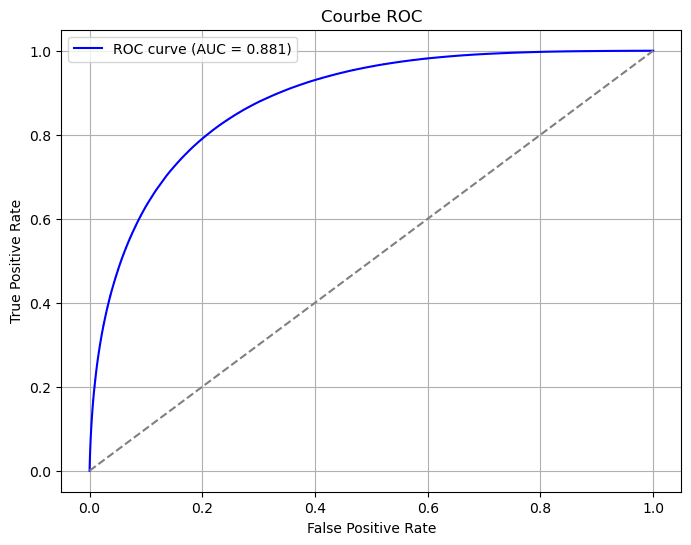

In [12]:
model = XGBClassifier(max_depth=6, n_estimators = 200, random_state=8)

comp_CM_per_state("tx","tx",model)
comp_CM_per_state("usa","tx",model)

y_probs = model.predict_proba(features_usa)[:, 1]

# Calcul des coordonnées ROC
fpr, tpr, thresholds = roc_curve(label_usa, y_probs)

# AUC
auc_score = roc_auc_score(label_usa, y_probs)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.3f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # ligne diagonale
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC")
plt.legend()
plt.grid(True)
plt.show()

### Skrub sur TX + prédiction sur USA

/home/luana/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Données : TX // Modèle fait sur : TX
0.5988479160531561
[[22368  3484]
 [ 4052 10874]] 

       - Disparate Impact = (0.5591971628079385, [0.5430921801792254, 0.5753021454366516])
       - Equality of Odds = (0.8190706514434507, [0.8005964607388444, 0.837544842148057])
       - Sufficiency = (0.9640284364481229, [0.9445742619858513, 0.9834826109103945]) 



/home/luana/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Données : USA // Modèle fait sur : TX
0.580949007672042
[[2294033  401589]
 [ 386151 1051298]] 

       - Disparate Impact = (0.5640626902073466, [0.562464606084154, 0.5656607743305391])
       - Equality of Odds = (0.8312812201598133, [0.8294133856998087, 0.8331490546198179])
       - Sufficiency = (0.9620608794784528, [0.9599764897622297, 0.9641452691946758]) 



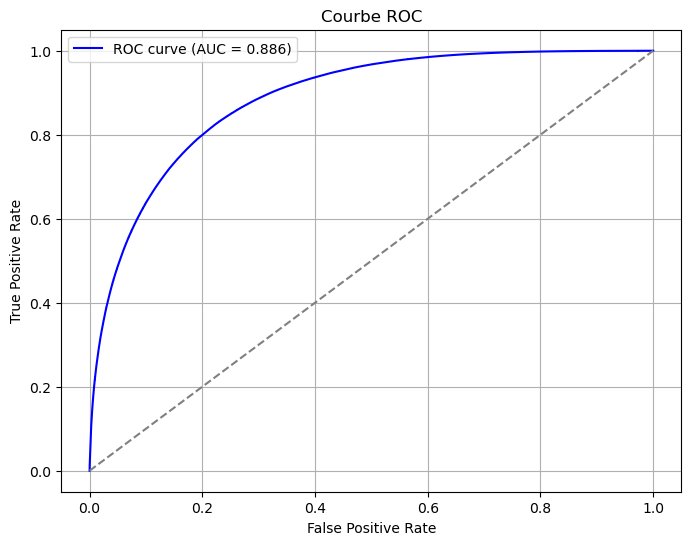

In [13]:
model=tabular_learner('classifier')

comp_CM_per_state("tx","tx",model,"Skrub")
comp_CM_per_state("usa","tx",model,"Skrub")

y_probs = model.predict_proba(features_usa)[:, 1]

# Calcul des coordonnées ROC
fpr, tpr, thresholds = roc_curve(label_usa, y_probs)

# AUC
auc_score = roc_auc_score(label_usa, y_probs)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.3f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # ligne diagonale
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC")
plt.legend()
plt.grid(True)
plt.show()

### Neural Network sur TX + prédiction sur USA

In [14]:
#usefull for preprocessing data, before using gems2
from tqdm import tqdm  
import torch
import torch.nn as nn

#1) define the NN classifier model
class MyNN(nn.Module):
    def __init__(self,p):
            
            super().__init__()  #p is the dimension of the inputs
            self.fc1 = nn.Linear(p, p)
            self.relu1 = nn.ReLU()
            self.dout1 = nn.Dropout(0.1)
            self.fc2 = nn.Linear(p, p)
            self.relu2 = nn.ReLU()
            self.dout2 = nn.Dropout(0.05)
            self.fc3 = nn.Linear(p, p)
            self.relu3 = nn.ReLU()
            self.dout3 = nn.Dropout(0.05)
            self.fc4 = nn.Linear(p, 1)
            self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
            a1 = self.fc1(input_)
            h1 = self.relu1(a1)
            dout1 = self.dout1(h1)
            a2 = self.fc2(dout1)
            h2 = self.relu2(a2)
            dout2 = self.dout2(h2)
            a3 = self.fc3(dout2)
            h3 = self.relu3(a3)
            dout3 = self.dout3(h3)
            a4 = self.fc4(dout3)
            y = self.out_act(a4)
            return y
        
    def predict(self,input_):
            pred = self.forward(input_)
            
            return torch.tensor(1.*(pred>0.5))
    
    def predict_proba(self,input_):
            pred = self.forward(input_)
            
            return torch.tensor(pred)



class SimpleNNclassifier:
    """
    Instanciate and train a simple NN classifier using a single command line. Although Pytorch is
    used in this class, all inputs and outputs are numpy arrays.
    
    * This class is initiated and trained with the inputs:
      -> A numpy array X of input observations
      -> A numpy array y of output observations with labels
    
    * As in sklearn, the predict method will used to predict y
    on new observations have the same structure as X.
    """
    
    def __init__(self,p):
        self.p = p
        print('SimpleNNclassifier created')
        
    #2) init method of SimpleNNclassifier
    def fit(self,X_train,y_train,epochs_nb=1000,batch_size=300,optimizer='SGD'):
        """
        parameters:
         - epochs_nb: epochs number
         - batch_size: batch size
         - optimizer: optimizer in ['SGD','ADAM']
        """
        #2.1) instantiate and parametrize the model
        X_trainS=sk.preprocessing.scale(X_train)
        
        n=X_trainS.shape[0]
        p=X_trainS.shape[1]

        #Initialize the model
        self.model = MyNN(self.p)
        #Define loss criterion
        #criterion = nn.BCELoss()
        criterion = nn.MSELoss()
        #Define the optimizer
        if optimizer=='SGD':
            optimizer = torch.optim.SGD(self.model.parameters(),lr=0.0001)
        else:
            optimizer = torch.optim.Adam(self.model.parameters())
        
        #2.3) train the model
        
        losses_train = []
        for i in tqdm(range(epochs_nb)):
            for beg_i in range(0, n-batch_size-1, batch_size):
                X = torch.from_numpy(X_trainS[beg_i:beg_i+batch_size,:].astype(np.float32))
                y = torch.from_numpy(y_train.reshape(-1,1)[beg_i:beg_i+batch_size,:].astype(np.float32))
                
                #Precit the output for Given input
                y_pred = self.model.forward(X)
                #Compute Cross entropy loss
                loss = criterion(y_pred,y)
                #Add loss to the list
                losses_train.append(loss.item())

                ###losses_women_train.append(loss_women.item())

                ###losses_men_train.append(loss_men.item())
                #Compute gradients
                loss.backward()
                #Adjust weights
                optimizer.step()
        plt.plot(losses_train)
        plt.show()
    
    #3) Prediction
    def predict(self,X_test):
        X_testS=sk.preprocessing.scale(X_test)
        X_test_torch = torch.from_numpy(X_testS.astype(np.float32))
        y_test_pred_torch=self.model.predict(X_test_torch)
        return y_test_pred_torch.numpy()

    def predict_proba(self,X_test):
        X_testS=sk.preprocessing.scale(X_test)
        X_test_torch = torch.from_numpy(X_testS.astype(np.float32))
        y_test_pred_torch=self.model.predict_proba(X_test_torch)
        return 1.-y_test_pred_torch.numpy()  #probability to be equal to 0 actually

SimpleNNclassifier created


100%|█████████████████████████████████████████| 100/100 [00:28<00:00,  3.51it/s]


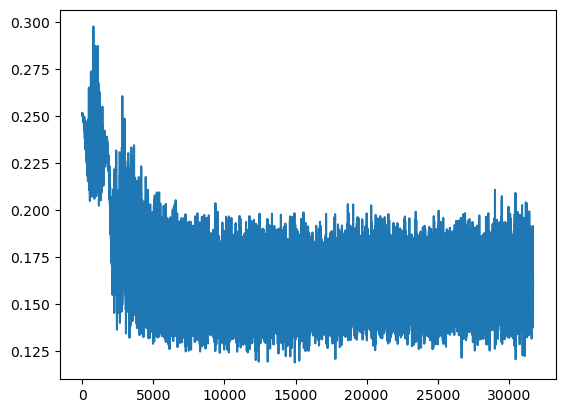

/tmp/ipykernel_14160/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


Données : TX // Modèle fait sur : TX
0.5028521070469747
[[19210  6729]
 [ 3276 11563]] 

       - Disparate Impact = (0.754035850812966, [0.7372171894611552, 0.7708545121647767])
       - Equality of Odds = (0.9440068130605083, [0.9264844902117721, 0.9615291359092444])
       - Sufficiency = (0.7907250924152416, [0.7714196012984786, 0.8100305835320045]) 



100%|█████████████████████████████████████████| 100/100 [00:14<00:00,  7.06it/s]


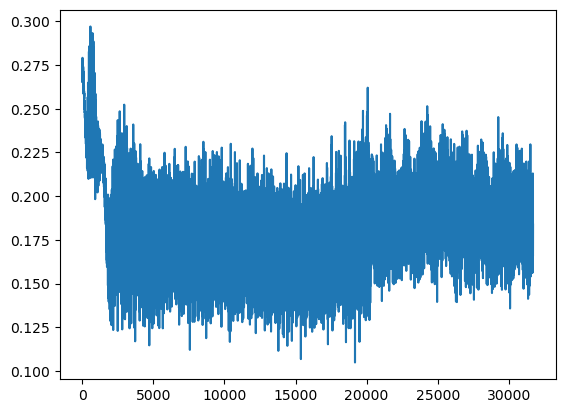

/tmp/ipykernel_14160/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


Données : USA // Modèle fait sur : TX


/tmp/ipykernel_14160/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


0.4699723262205679


/tmp/ipykernel_14160/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


[[1656222 1039400]
 [ 178596 1258853]] 

       - Disparate Impact = (0.7772538652222171, [0.7758742685482386, 0.7786334618961955])
       - Equality of Odds = (0.9496997839748564, [0.9484283221692716, 0.9509712457804412])
       - Sufficiency = (0.7976372161071763, [0.7956329184869756, 0.799641513727377]) 



/tmp/ipykernel_14160/3409401895.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(pred)


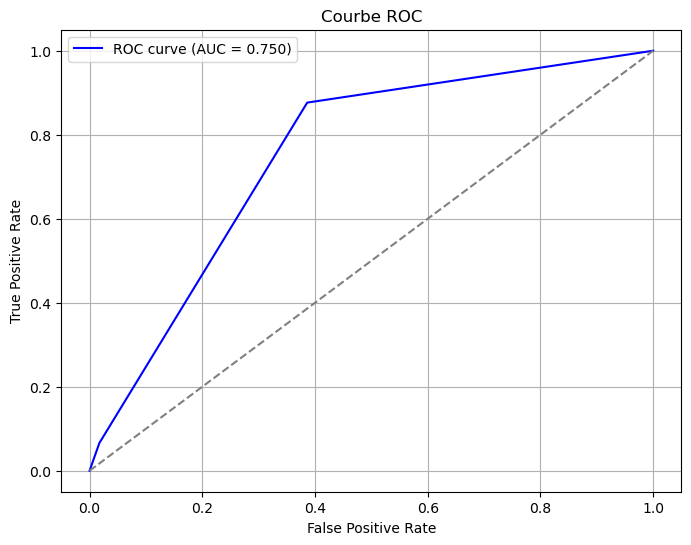

In [15]:
model = SimpleNNclassifier(10)

comp_CM_per_state("tx","tx",model,"NN")
comp_CM_per_state("usa","tx",model,"NN")

y_probs = 1-model.predict_proba(features_usa).ravel()

# Calcul des coordonnées ROC
fpr, tpr, thresholds = roc_curve(label_usa, y_probs)

# AUC
auc_score = roc_auc_score(label_usa, y_probs)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.3f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # ligne diagonale
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC")
plt.legend()
plt.grid(True)
plt.show()